## To what extent does economic activity cause CO2 emission? ##

In [247]:
import wbdata
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import statsmodels.api as sm
import statsmodels.formula.api as smf

### Data Description ###
The dataset consists of indicators for GDP per capita and CO2 emissions per capita from the World Bank. It covers all countries and spans from 1992 onward. The variables include:

gdp_per_capita: GDP per capita in constant international dollars (PPP, 2017 prices).
co2_per_capita: CO2 emissions per capita in metric tons.
The data has been merged with country metadata for sovereign nations, retaining only countries with adequate coverage. This includes filtering out aggregates and non-sovereign entities.

The dataset contains annual data on GDP per capita and CO2 emissions per capita for 217 countries, spanning from 1992 to 2023. 
Country metadata, including sovereign state classifications and income levels, was sourced from the World Bank API using the `wbdata.get_countries()` function. 
Non-sovereign entities, such as aggregates, regions, or territories, were excluded by filtering out entries labeled as 'Aggregates' in the `region` or `incomeLevel` fields, and those lacking a capital city or administrative region.

GDP per capita ranges from $510 to $174,339, while CO2 emissions per capita vary from 0 to 202 metric tons. 
Income levels are classified based on World Bank criteria, providing a contextual understanding of the economic status of each country. 
There is a moderate positive correlation (0.43) between GDP per capita and CO2 emissions per capita, suggesting that wealthier countries tend to have higher emissions. 
The interactive plot provides the ability to explore trends for individual countries over time.

In [250]:
# Define the indicators
indicators = {
    "NY.GDP.PCAP.PP.KD": "gdp_per_capita",
    "EN.GHG.CO2.PC.CE.AR5": "co2_per_capita"
}

# Fetch data for the indicators
data = wbdata.get_dataframe(indicators, country="all")

# Export raw data to CSV
data.to_csv("raw_data.csv")

# Print head and shape of raw data
print("Raw Data:")
print(data.head())
print("\nShape of Raw Data:", data.shape)

# Reset index and rename columns correctly
data = data.reset_index().rename(columns={'country': 'country_name', 'date': 'year'})

# Convert year to numeric and filter
data['year'] = pd.to_numeric(data['year'])
data = data[data['year'] >= 1992]

# Print head and shape of filtered data
print("\nFiltered Data (Year >= 1992):")
print(data.head())
print("\nShape of Filtered Data:", data.shape)

# Fetch country metadata (sovereign nations + aggregates)
countries_metadata = wbdata.get_countries()

# Convert metadata to a DataFrame
countries_df = pd.DataFrame(countries_metadata)

# Filter sovereign nations
sovereign_nations = countries_df[
    (countries_df['region'].apply(lambda x: x['value']) != 'Aggregates') &  # Exclude aggregates
    (countries_df['incomeLevel'].apply(lambda x: x['value']) != 'Aggregates') &  # Exclude aggregates
    (countries_df['capitalCity'].notna()) &  # Exclude rows without a capital city
    (countries_df['adminregion'].notna())  # Exclude rows without an admin region
]

# Create a clean dataframe of sovereign nation codes and names, including income level, region, and capital city
sovereign_nations_clean = sovereign_nations[['id', 'name', 'incomeLevel', 'region', 'capitalCity']].rename(columns={
    'id': 'country_code',
    'name': 'country_name',
    'incomeLevel': 'income_level',
    'region': 'region',
    'capitalCity': 'capital_city'
})

# Merge indicator data with sovereign nations metadata on country_name
data = pd.merge(data, sovereign_nations_clean, on='country_name', how='inner')

# Print head and shape of data after merging with sovereign nations
print("\nData After Merging with Sovereign Nations:")
print(data.head())
print("\nShape of Data After Merging:", data.shape)

# Set year as the index
data = data.set_index('year')

# Reset the index to make 'year' a column again
data_reset = data.reset_index()

# Export final data to CSV
data_reset.to_csv("final_data_sovereign_only.csv", index=False)

# Print head and shape of final data
print("\nFinal Data:")
print(data_reset.head())
print("\nShape of Final Data:", data_reset.shape)


Raw Data:
                                  gdp_per_capita  co2_per_capita
country                     date                                
Africa Eastern and Southern 2023     3967.860937        0.784641
                            2022     3974.803045        0.816361
                            2021     3934.287267        0.863533
                            2020     3861.111238        0.845417
                            2019     4073.880522        0.983492

Shape of Raw Data: (17024, 2)

Filtered Data (Year >= 1992):
                  country_name  year  gdp_per_capita  co2_per_capita
0  Africa Eastern and Southern  2023     3967.860937        0.784641
1  Africa Eastern and Southern  2022     3974.803045        0.816361
2  Africa Eastern and Southern  2021     3934.287267        0.863533
3  Africa Eastern and Southern  2020     3861.111238        0.845417
4  Africa Eastern and Southern  2019     4073.880522        0.983492

Shape of Filtered Data: (8512, 4)

Data After Merging with

In [252]:
print(data.isnull().sum())

country_name        0
gdp_per_capita    728
co2_per_capita    448
country_code        0
income_level        0
region              0
capital_city        0
dtype: int64


In [254]:
# Load the final dataset
data = data_reset

# Display basic information
print("=== Basic Information ===")
print("Number of observations (rows):", data.shape[0])
print("Number of variables (columns):", data.shape[1])
print("\nData types:")
print(data.dtypes)

# Display time-series characteristics
print("\n=== Time-Series Characteristics ===")
print("Time range:", data['year'].min(), "to", data['year'].max())
print("Number of unique years:", data['year'].nunique())
print("Number of unique countries:", data['country_name'].nunique())

# Descriptive statistics for numerical variables
print("\n=== Descriptive Statistics for Numerical Variables ===")
print("GDP per Capita:")
print(data['gdp_per_capita'].describe())
print("\nCO2 Emissions per Capita:")
print(data['co2_per_capita'].describe())

# Extract values from the dictionaries for the new columns
data['income_level'] = data['income_level'].apply(lambda x: x['value'] if isinstance(x, dict) else x)
data['region'] = data['region'].apply(lambda x: x['value'] if isinstance(x, dict) else x)
data['capital_city'] = data['capital_city'].apply(lambda x: x if isinstance(x, str) else None)

# Descriptive statistics for categorical variables
print("\n=== Descriptive Statistics for Categorical Variables ===")
print("Country Name:")
print("Number of unique countries:", data['country_name'].nunique())
print("\nCountry Code:")
print("Number of unique codes:", data['country_code'].nunique())
print("\nIncome Level:")
print("Number of unique income levels:", data['income_level'].nunique())
print("\nRegion:")
print("Number of unique regions:", data['region'].nunique())
print("\nCapital City:")
print("Number of unique capital cities:", data['capital_city'].nunique())


# Missing data analysis
print("\n=== Missing Data ===")
print("Missing values in GDP per Capita:", data['gdp_per_capita'].isna().sum())
print("Missing values in CO2 Emissions per Capita:", data['co2_per_capita'].isna().sum())



=== Basic Information ===
Number of observations (rows): 6944
Number of variables (columns): 8

Data types:
year                int64
country_name       object
gdp_per_capita    float64
co2_per_capita    float64
country_code       object
income_level       object
region             object
capital_city       object
dtype: object

=== Time-Series Characteristics ===
Time range: 1992 to 2023
Number of unique years: 32
Number of unique countries: 217

=== Descriptive Statistics for Numerical Variables ===
GDP per Capita:
count      6216.000000
mean      21925.450833
std       24141.257785
min         510.822823
25%        4371.469342
50%       12728.473141
75%       32487.154463
max      174339.077325
Name: gdp_per_capita, dtype: float64

CO2 Emissions per Capita:
count    6496.000000
mean        4.864490
std         9.449697
min         0.000000
25%         0.511913
50%         2.169578
75%         6.199406
max       202.865184
Name: co2_per_capita, dtype: float64

=== Descriptive Statist

In [256]:
# Check for countries with missing capital cities
countries_without_capital = data[data['capital_city'].isna()]

# Display the countries without capital cities
print("\nCountries without capital cities:")
print(countries_without_capital[['country_name', 'capital_city']])

# Optionally, check how many there are
print("\nNumber of countries without capital cities:", countries_without_capital.shape[0])



Countries without capital cities:
Empty DataFrame
Columns: [country_name, capital_city]
Index: []

Number of countries without capital cities: 0


In [258]:
# Count the number of occurrences of each capital city per country
capital_counts = data.groupby('country_name')['capital_city'].nunique()

# Find countries with more than one capital city
countries_with_multiple_capitals = capital_counts[capital_counts > 1]

# Display countries with multiple capitals
print("\nCountries with multiple capitals:")
print(countries_with_multiple_capitals)

# Optionally, check how many there are
print("\nNumber of countries with multiple capitals:", countries_with_multiple_capitals.shape[0])



Countries with multiple capitals:
Series([], Name: capital_city, dtype: int64)

Number of countries with multiple capitals: 0


In [260]:
# Count occurrences of each capital city across the years
capital_city_counts = data['capital_city'].value_counts()

# Display capital cities with their counts
print("\nCapital Cities Frequency:")
print(capital_city_counts)

# Optionally, display only capital cities that appear more than once
print("\nCapital Cities Appearing More Than Once:")
print(capital_city_counts[capital_city_counts > 1])



Capital Cities Frequency:
capital_city
                  192
Kabul              32
Kathmandu          32
Noum'ea            32
Wellington         32
                 ... 
Accra              32
Athens             32
Nuuk               32
Saint George's     32
Harare             32
Name: count, Length: 212, dtype: int64

Capital Cities Appearing More Than Once:
capital_city
                  192
Kabul              32
Kathmandu          32
Noum'ea            32
Wellington         32
                 ... 
Accra              32
Athens             32
Nuuk               32
Saint George's     32
Harare             32
Name: count, Length: 212, dtype: int64


C:\Users\zunai\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

C:\Users\zunai\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



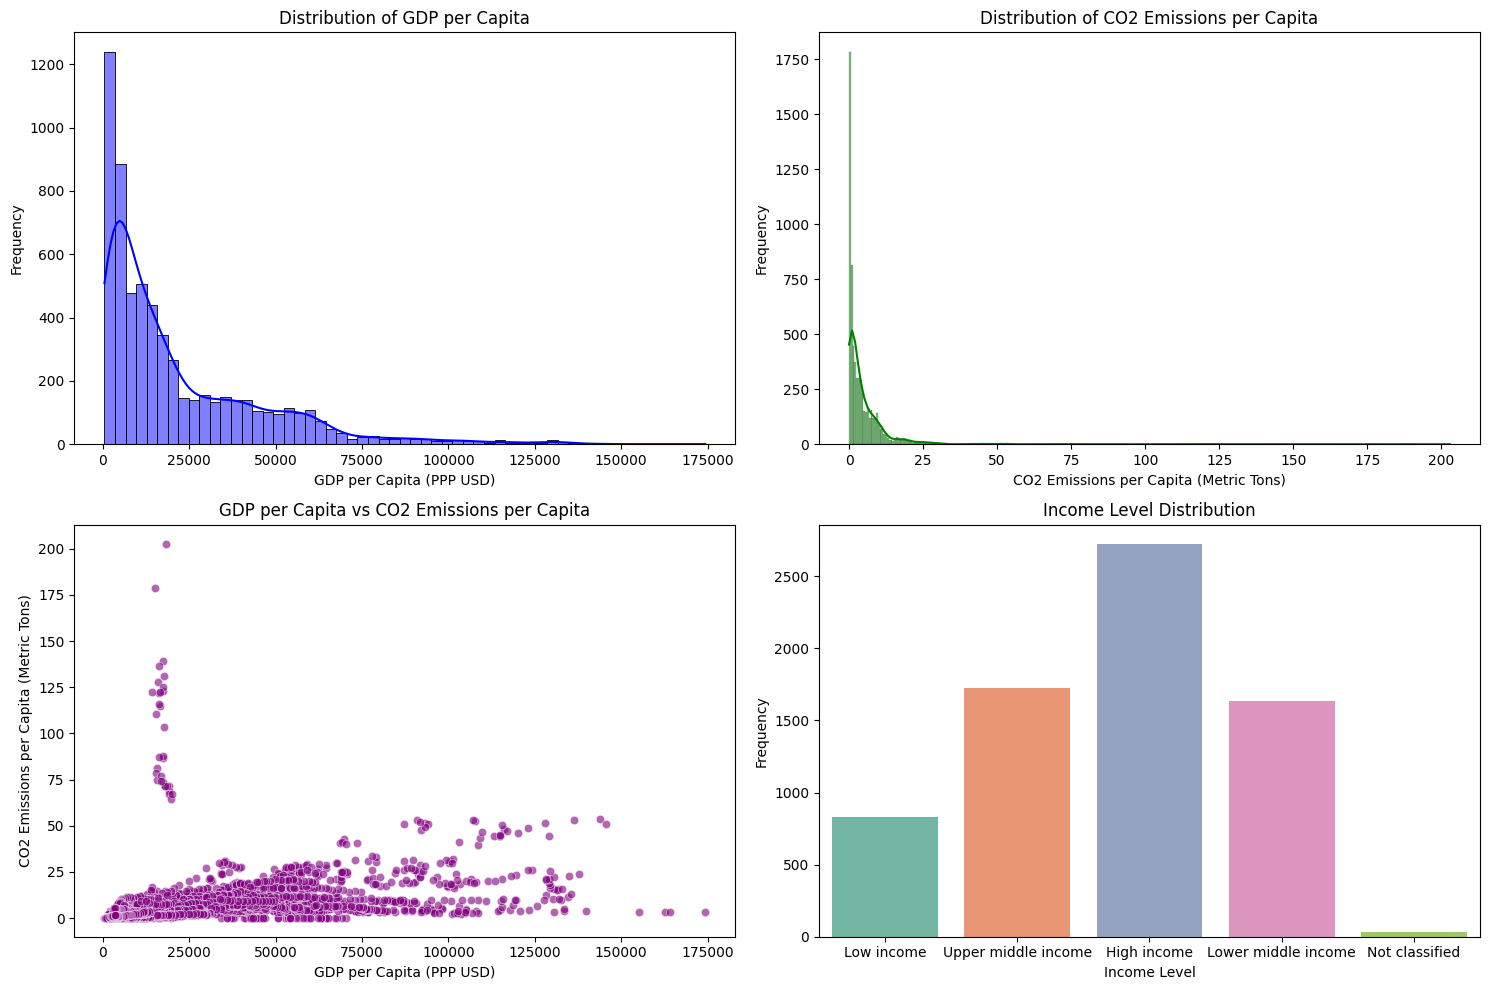

In [262]:
# Visualizations
plt.figure(figsize=(15, 10))

# Histograms for GDP per Capita and CO2 Emissions per Capita
plt.subplot(2, 2, 1)
sns.histplot(data['gdp_per_capita'], kde=True, color='blue')
plt.title('Distribution of GDP per Capita')
plt.xlabel('GDP per Capita (PPP USD)')
plt.ylabel('Frequency')

plt.subplot(2, 2, 2)
sns.histplot(data['co2_per_capita'], kde=True, color='green')
plt.title('Distribution of CO2 Emissions per Capita')
plt.xlabel('CO2 Emissions per Capita (Metric Tons)')
plt.ylabel('Frequency')

# Scatter plot for GDP per Capita vs CO2 Emissions per Capita
plt.subplot(2, 2, 3)
sns.scatterplot(x='gdp_per_capita', y='co2_per_capita', data=data, alpha=0.6, color='purple')
plt.title('GDP per Capita vs CO2 Emissions per Capita')
plt.xlabel('GDP per Capita (PPP USD)')
plt.ylabel('CO2 Emissions per Capita (Metric Tons)')

# Bar plot for Income Level
plt.subplot(2, 2, 4)
sns.countplot(x='income_level', data=data, palette='Set2')
plt.title('Income Level Distribution')
plt.xlabel('Income Level')
plt.ylabel('Frequency')

# Show plots
plt.tight_layout()
plt.show()


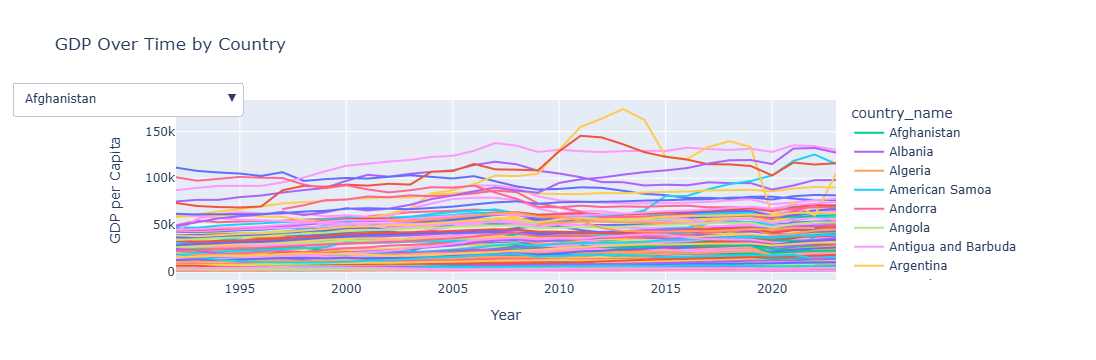

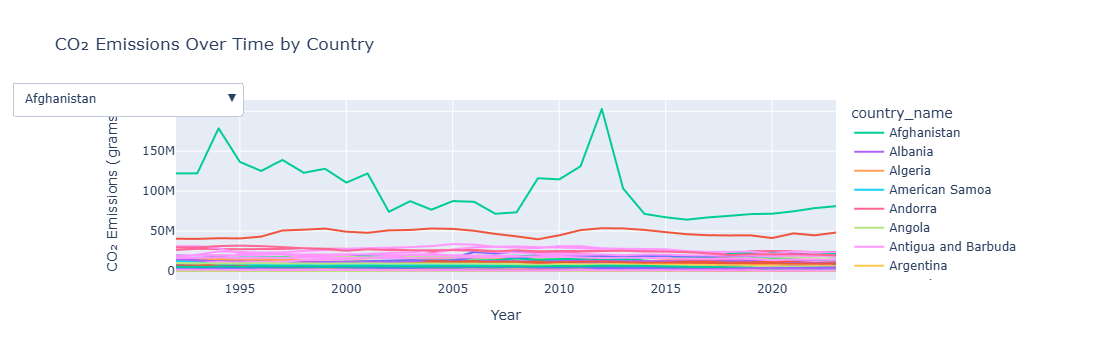

In [284]:
# Scale CO₂ emissions for better comparability
data['co2_per_capita_scaled'] = data['co2_per_capita'] * 1_000_000  # Convert metric tons to grams for better visibility

# Melt the dataframe to long format for Plotly
data_melted = data.melt(id_vars=['year', 'country_name'], 
                         value_vars=['gdp_per_capita', 'co2_per_capita_scaled'],
                         var_name='Indicator', value_name='Value')

# Define custom colors for clarity
color_map = {
    'gdp_per_capita': 'blue',      # GDP in blue
    'co2_per_capita_scaled': 'red' # CO₂ emissions in red
}

# Plot for GDP
fig_gdp = px.line(data_melted[data_melted['Indicator'] == 'gdp_per_capita'], 
                  x='year', y='Value', 
                  color='country_name', 
                  title='GDP Over Time by Country',
                  labels={'Value': 'GDP per Capita', 'year': 'Year'},
                  hover_data={'country_name': True, 'year': True, 'Value': ':.2f'},
                  color_discrete_map=color_map)

# Plot for CO₂ Emissions
fig_co2 = px.line(data_melted[data_melted['Indicator'] == 'co2_per_capita_scaled'], 
                  x='year', y='Value', 
                  color='country_name', 
                  title='CO₂ Emissions Over Time by Country',
                  labels={'Value': 'CO₂ Emissions (grams)', 'year': 'Year'},
                  hover_data={'country_name': True, 'year': True, 'Value': ':.2f'},
                  color_discrete_map=color_map)

# Function to update visibility based on selected country
def update_visibility(country, data):
    visible_gdp = [country == c for c in data['country_name'].unique()]
    visible_co2 = [country == c for c in data['country_name'].unique()]
    return visible_gdp, visible_co2

# Add dropdown for selecting country for GDP plot
fig_gdp.update_layout(
    updatemenus=[
        {
            "buttons": [
                {
                    "method": "update",
                    "label": country,
                    "args": [
                        {"visible": update_visibility(country, data)[0]},  # GDP plot visibility
                        {"title": f"GDP Over Time for {country}"}
                    ],
                }
                for country in data['country_name'].unique()
            ],
            "direction": "down",
            "showactive": True,
            "x": 0.1,
            "y": 1.1,
        }
    ]
)

# Add dropdown for selecting country for CO₂ emissions plot
fig_co2.update_layout(
    updatemenus=[
        {
            "buttons": [
                {
                    "method": "update",
                    "label": country,
                    "args": [
                        {"visible": update_visibility(country, data)[1]},  # CO₂ plot visibility
                        {"title": f"CO₂ Emissions Over Time for {country}"}
                    ],
                }
                for country in data['country_name'].unique()
            ],
            "direction": "down",
            "showactive": True,
            "x": 0.1,
            "y": 1.1,
        }
    ]
)

# Show the GDP plot
fig_gdp.show()

# Show the CO₂ emissions plot
fig_co2.show()


In [286]:
# Identify rows with missing values
missing_data = data[data.isnull().any(axis=1)]

# Display the first few rows of missing data
print("Rows with missing values:")
print(missing_data.head())

Rows with missing values:
    year country_name  gdp_per_capita  co2_per_capita country_code  \
24  1999  Afghanistan             NaN        0.069163          AFG   
25  1998  Afghanistan             NaN        0.074134          AFG   
26  1997  Afghanistan             NaN        0.075038          AFG   
27  1996  Afghanistan             NaN        0.079783          AFG   
28  1995  Afghanistan             NaN        0.085727          AFG   

   income_level      region capital_city  co2_per_capita_scaled  
24   Low income  South Asia        Kabul           69163.056620  
25   Low income  South Asia        Kabul           74133.627168  
26   Low income  South Asia        Kabul           75037.566203  
27   Low income  South Asia        Kabul           79782.625560  
28   Low income  South Asia        Kabul           85726.828735  


In [288]:
# Identify rows with missing values and add an indicator column
missing_data = data[data.isnull().any(axis=1)].copy()  # Copy to preserve the original dataframe

# Add a new column indicating which rows have missing data
missing_data['missing_indicator'] = missing_data.isnull().any(axis=1)

# Display the first few rows of missing data with the indicator column
print("Rows with missing values (and indicator):")
print(missing_data.head())


Rows with missing values (and indicator):
    year country_name  gdp_per_capita  co2_per_capita country_code  \
24  1999  Afghanistan             NaN        0.069163          AFG   
25  1998  Afghanistan             NaN        0.074134          AFG   
26  1997  Afghanistan             NaN        0.075038          AFG   
27  1996  Afghanistan             NaN        0.079783          AFG   
28  1995  Afghanistan             NaN        0.085727          AFG   

   income_level      region capital_city  co2_per_capita_scaled  \
24   Low income  South Asia        Kabul           69163.056620   
25   Low income  South Asia        Kabul           74133.627168   
26   Low income  South Asia        Kabul           75037.566203   
27   Low income  South Asia        Kabul           79782.625560   
28   Low income  South Asia        Kabul           85726.828735   

    missing_indicator  
24               True  
25               True  
26               True  
27               True  
28            

In [290]:
# Group missing data by country and count missing values for each indicator
missing_by_country = missing_data.groupby('country_name').agg(
    missing_gdp=('gdp_per_capita', lambda x: x.isna().sum()),
    missing_co2=('co2_per_capita', lambda x: x.isna().sum())
).reset_index()

# Sort by the number of missing values (descending)
missing_by_country = missing_by_country.sort_values(by=['missing_gdp', 'missing_co2'], ascending=False)

# Display the top countries with missing values
print("Missing values by country:")
print(missing_by_country)

Missing values by country:
                 country_name  missing_gdp  missing_co2
6             Channel Islands           32           32
16                Isle of Man           32           32
20              Liechtenstein           32           32
21                     Monaco           32           32
28                South Sudan           32           32
29   St. Martin (French part)           32           32
1              American Samoa           32            0
4      British Virgin Islands           32            0
7                        Cuba           32            0
10                    Eritrea           32            0
12           French Polynesia           32            0
13                  Gibraltar           32            0
15                       Guam           32            0
17  Korea, Dem. People's Rep.           32            0
23              New Caledonia           32            0
24   Northern Mariana Islands           32            0
33              Venez

In [292]:
# Group missing data by year and count missing values for each indicator
missing_by_year = missing_data.groupby('year').agg(
    missing_gdp=('gdp_per_capita', lambda x: x.isna().sum()),
    missing_co2=('co2_per_capita', lambda x: x.isna().sum())
).reset_index()

# Sort by year
missing_by_year = missing_by_year.sort_values(by='year')

# Display missing values by year
print("Missing values by year:")
print(missing_by_year)

Missing values by year:
    year  missing_gdp  missing_co2
0   1992           31           14
1   1993           31           14
2   1994           30           14
3   1995           29           14
4   1996           29           14
5   1997           27           14
6   1998           27           14
7   1999           27           14
8   2000           25           14
9   2001           25           14
10  2002           24           14
11  2003           24           14
12  2004           24           14
13  2005           24           14
14  2006           23           14
15  2007           23           14
16  2008           21           14
17  2009           20           14
18  2010           20           14
19  2011           19           14
20  2012           19           14
21  2013           18           14
22  2014           18           14
23  2015           18           14
24  2016           18           14
25  2017           18           14
26  2018           18          

In [294]:
# Calculate the total number of years (32 in your case)
total_years = data['year'].nunique()

# Group by country and calculate the percentage of missing values for each indicator
missing_percentage = data.groupby('country_name').agg(
    missing_gdp_percentage=('gdp_per_capita', lambda x: x.isna().sum() / total_years * 100),
    missing_co2_percentage=('co2_per_capita', lambda x: x.isna().sum() / total_years * 100)
).reset_index()

# Display the missing percentages
print("Percentage of missing values by country:")
print(missing_percentage)

Percentage of missing values by country:
              country_name  missing_gdp_percentage  missing_co2_percentage
0              Afghanistan                  25.000                     0.0
1                  Albania                   0.000                     0.0
2                  Algeria                   0.000                     0.0
3           American Samoa                 100.000                     0.0
4                  Andorra                   0.000                   100.0
..                     ...                     ...                     ...
212  Virgin Islands (U.S.)                  34.375                     0.0
213     West Bank and Gaza                   6.250                   100.0
214            Yemen, Rep.                 100.000                     0.0
215                 Zambia                   0.000                     0.0
216               Zimbabwe                   0.000                     0.0

[217 rows x 3 columns]


### Coverage and Missing Values ###
Countries with poor coverage were dropped using the criteria that if more than 50% of the data for any indicator is missing over the total number of years, that country is excluded. This was verified in the code by calculating the percentage of missing values for each indicator and then filtering out countries accordingly.

In [297]:
# Identify countries with more than 50% missing values for either indicator
countries_to_drop = missing_percentage[
    (missing_percentage['missing_gdp_percentage'] > 50) |
    (missing_percentage['missing_co2_percentage'] > 50)
]['country_name'].tolist()

# Display the list of countries to drop
print("Countries to drop (more than 50% missing values for either indicator):")
print(countries_to_drop)

Countries to drop (more than 50% missing values for either indicator):
['American Samoa', 'Andorra', 'British Virgin Islands', 'Channel Islands', 'Cuba', 'Curacao', 'Djibouti', 'Eritrea', 'French Polynesia', 'Gibraltar', 'Guam', 'Isle of Man', "Korea, Dem. People's Rep.", 'Kosovo', 'Liechtenstein', 'Monaco', 'Montenegro', 'New Caledonia', 'Northern Mariana Islands', 'San Marino', 'Serbia', 'Sint Maarten (Dutch part)', 'South Sudan', 'St. Martin (French part)', 'Turks and Caicos Islands', 'Venezuela, RB', 'West Bank and Gaza', 'Yemen, Rep.']


In [299]:
# Drop countries with more than 50% missing values for either indicator
data_cleaned = data[~data['country_name'].isin(countries_to_drop)]

# Display the shape of the cleaned dataset
print("\nShape of the dataset after dropping countries:")
print(data_cleaned.shape)


Shape of the dataset after dropping countries:
(6048, 9)


In [301]:
# Check unique countries in the cleaned dataset
print("\nUnique countries in the cleaned dataset:")
print(data_cleaned['country_name'].unique())
print(f"Number of unique countries after cleaning: {data_cleaned['country_name'].nunique()}")


Unique countries in the cleaned dataset:
['Afghanistan' 'Albania' 'Algeria' 'Angola' 'Antigua and Barbuda'
 'Argentina' 'Armenia' 'Aruba' 'Australia' 'Austria' 'Azerbaijan'
 'Bahamas, The' 'Bahrain' 'Bangladesh' 'Barbados' 'Belarus' 'Belgium'
 'Belize' 'Benin' 'Bermuda' 'Bhutan' 'Bolivia' 'Bosnia and Herzegovina'
 'Botswana' 'Brazil' 'Brunei Darussalam' 'Bulgaria' 'Burkina Faso'
 'Burundi' 'Cabo Verde' 'Cambodia' 'Cameroon' 'Canada' 'Cayman Islands'
 'Central African Republic' 'Chad' 'Chile' 'China' 'Colombia' 'Comoros'
 'Congo, Dem. Rep.' 'Congo, Rep.' 'Costa Rica' "Cote d'Ivoire" 'Croatia'
 'Cyprus' 'Czechia' 'Denmark' 'Dominica' 'Dominican Republic' 'Ecuador'
 'Egypt, Arab Rep.' 'El Salvador' 'Equatorial Guinea' 'Estonia' 'Eswatini'
 'Ethiopia' 'Faroe Islands' 'Fiji' 'Finland' 'France' 'Gabon'
 'Gambia, The' 'Georgia' 'Germany' 'Ghana' 'Greece' 'Greenland' 'Grenada'
 'Guatemala' 'Guinea' 'Guinea-Bissau' 'Guyana' 'Haiti' 'Honduras'
 'Hong Kong SAR, China' 'Hungary' 'Iceland' 'India'

In [303]:
# Save the cleaned dataset to a new CSV file
data_cleaned.to_csv("cleaned_data.csv", index=False)
print("\nCleaned dataset saved to 'cleaned_data.csv'.")


Cleaned dataset saved to 'cleaned_data.csv'.


## Models and their Estimated Coefficients Discussion ##

### Model 1: Cross-section OLS for the year 2005 ###

In [307]:
data = data_cleaned

# 1. Cross-Sectional OLS for the year 2005
data_2005 = data[data['year'] == 2005].copy()
# Drop rows with missing values in relevant variables
data_2005 = data_2005[['country_name', 'gdp_per_capita', 'co2_per_capita']].dropna()
model_2005 = smf.ols(formula='co2_per_capita ~ gdp_per_capita', data=data_2005).fit()
print("OLS for 2005:")
print(model_2005.summary())

OLS for 2005:
                            OLS Regression Results                            
Dep. Variable:         co2_per_capita   R-squared:                       0.302
Model:                            OLS   Adj. R-squared:                  0.298
Method:                 Least Squares   F-statistic:                     80.07
Date:                Sun, 16 Feb 2025   Prob (F-statistic):           3.76e-16
Time:                        22:47:44   Log-Likelihood:                -644.74
No. Observations:                 187   AIC:                             1293.
Df Residuals:                     185   BIC:                             1300.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.8093     

#### About 30.2% of the variation in GDP per capita is explained by CO₂ per capita in 2005 by this model ####
#### The statistically significant coefficient for GDP per capita (0.0002) suggests that each one-unit increase in GDP per capita is associated with a 0.0002 metric ton increase in CO2 emissions per capita. ####

### Model 2: Cross-section OLS for the last year ###

In [311]:
# 2. Cross-Sectional OLS for the Last Available Year
last_year = data['year'].max()
data_last = data[data['year'] == last_year].copy()
data_last = data_last[['country_name', 'gdp_per_capita', 'co2_per_capita']].dropna()
model_last = smf.ols(formula='co2_per_capita ~ gdp_per_capita', data=data_last).fit()
print(f"\nOLS for {last_year}:")
print(model_last.summary())


OLS for 2023:
                            OLS Regression Results                            
Dep. Variable:         co2_per_capita   R-squared:                       0.165
Model:                            OLS   Adj. R-squared:                  0.161
Method:                 Least Squares   F-statistic:                     35.85
Date:                Sun, 16 Feb 2025   Prob (F-statistic):           1.12e-08
Time:                        22:47:45   Log-Likelihood:                -623.45
No. Observations:                 183   AIC:                             1251.
Df Residuals:                     181   BIC:                             1257.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          1.4166    

About **16.5%** of the variation in CO2 emissions per capita is explained by GDP per capita in **2023**.

The statistically significant **coefficient for GDP per capita (0.0001)** suggests that each one-unit increase in GDP per capita is associated with a **0.0001 metric ton increase** in CO2 emissions per capita.

### Model 3: First difference model, with time trend, no lags ###

In [315]:
# First, sort the data by country and year.
data_panel = data.sort_values(['country_name', 'year']).copy()

# Create a time trend variable (if not already present)
data_panel['time_trend'] = data_panel['year'] - data_panel['year'].min()

# Group by country and compute first differences for the variables
diff_vars = ['gdp_per_capita', 'co2_per_capita', 'time_trend']
for var in diff_vars:
    data_panel[f'd_{var}'] = data_panel.groupby('country_name')[var].diff()

# Drop the first year for each country (because diff will be NaN)
data_fd = data_panel.dropna(subset=[f'd_gdp_per_capita', f'd_co2_per_capita', 'd_time_trend']).copy()

# 3. First Difference Model, with Time Trend, No Lags
model_fd0 = smf.ols(formula=' d_co2_per_capita ~ d_gdp_per_capita + d_time_trend', data=data_fd).fit()
print("\nFirst Difference Model (No Lags):")
print(model_fd0.summary())


First Difference Model (No Lags):
                            OLS Regression Results                            
Dep. Variable:       d_co2_per_capita   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     16.86
Date:                Sun, 16 Feb 2025   Prob (F-statistic):           4.08e-05
Time:                        22:47:46   Log-Likelihood:                -12870.
No. Observations:                5804   AIC:                         2.574e+04
Df Residuals:                    5802   BIC:                         2.576e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Inter

This model examines the relationship between the change in GDP and the change in CO2 emissions per capita without considering any lags for GDP.

**Intercept = -0.0145 (p = 0.325):**
The intercept is not statistically significant, suggesting that when the change in GDP and the time trend are both zero, there is no significant baseline change in CO2 emissions per capita.

**β1 (Change in GDP) = 6.033e-05 (p = 0.000):**
A one-unit increase in the change in GDP per capita leads to a 0.00006033 increase in the change in CO2 emissions per capita. This result is statistically significant (p < 0.05), indicating that changes in GDP have a positive and meaningful effect on changes in CO2 emissions per capita.

**Time Trend = -0.0145 (p = 0.325):**
The time trend coefficient is not statistically significant (p > 0.05), suggesting that the passage of time alone does not significantly influence changes in CO2 emissions per capita.

**Model Fit (R² = 0.003):**
The model explains only 0.3% of the variation in CO2 emissions, indicating that the change in GDP per capita has a very small explanatory power for the changes in CO2 emissions.

While the change in GDP has a statistically significant effect on CO2 emissions, the overall model explains very little of the variation in CO2 emissions. This suggests that while economic growth may influence emissions, other factors, not included in the model, are likely playing a more substantial role in determining changes in CO2 emissions. The poor model fit and potential multicollinearity issues point to the need for further refinement or additional variables to improve explanatory power.

### Model 4: First difference model, with time trend, 2 year lags ###

In [319]:
# 4. First Difference Model, with Time Trend, 2-Year Lags
# Create 2-year lag for d_gdp_per_capita
data_panel['d_gdp_per_capita_lag2'] = data_panel.groupby('country_name')['d_gdp_per_capita'].shift(2)
data_fd_lag2 = data_panel.dropna(subset=['d_gdp_per_capita', 'd_co2_per_capita', 'd_time_trend', 'd_gdp_per_capita_lag2'])

# Model with lagged GDP
model_fd2 = smf.ols(formula='d_co2_per_capita ~ d_gdp_per_capita_lag2 + d_time_trend', data=data_fd_lag2).fit()
print("\nFirst Difference Model (2-Year Lag on GDP):")
print(model_fd2.summary())


First Difference Model (2-Year Lag on GDP):
                            OLS Regression Results                            
Dep. Variable:       d_co2_per_capita   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.2902
Date:                Sun, 16 Feb 2025   Prob (F-statistic):              0.590
Time:                        22:47:47   Log-Likelihood:                -11891.
No. Observations:                5426   AIC:                         2.379e+04
Df Residuals:                    5424   BIC:                         2.380e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------

The regression model examines the relationship between changes in GDP and changes in CO2 emissions per capita over a 2-year lag.

**Intercept = -0.0111 (p = 0.454):**
Not statistically significant, suggesting the model's intercept does not meaningfully affect the change in CO2 emissions.

**β1 (Current GDP Change) = 8.297e-06 (p = 0.590):**
The effect of current GDP change on CO2 emissions is minimal and not statistically significant (p > 0.05). This indicates that current GDP changes do not meaningfully affect the change in CO2 emissions per capita.

**β2 (Lagged GDP Change, 2 years) = 8.297e-06 (p = 0.590):**
The lagged effect of GDP changes (2 years ago) also has no significant impact on CO2 emissions (p > 0.05), indicating that changes in GDP from two years ago do not explain current CO2 changes.

**Time Trend = -0.0111 (p = 0.454):**
The time trend coefficient is not statistically significant, suggesting that the passage of time alone does not contribute significantly to changes in CO2 emissions.

**Model Fit (R² = 0.000):**
The model explains virtually none of the variation in CO2 emissions, meaning the changes in GDP (both current and lagged) and time trend do not provide meaningful explanatory power for changes in CO2 emissions per capita.

Neither current nor lagged GDP changes have a significant impact on CO2 emissions. The model's poor fit suggests that other factors, not captured by this model, are influencing changes in CO2 emissions per capita.

### Model 5: First difference model, with time trend, 6 year lags ###

In [323]:
# 5. First Difference Model, with Time Trend, 6-Year Lags
# Create 6-year lag for d_gdp_per_capita
data_panel['d_gdp_per_capita_lag6'] = data_panel.groupby('country_name')['d_gdp_per_capita'].shift(6)
data_fd_lag6 = data_panel.dropna(subset=['d_gdp_per_capita', 'd_co2_per_capita', 'd_time_trend', 'd_gdp_per_capita_lag6'])

# Model with 6-year lag on GDP
model_fd6 = smf.ols(formula='d_co2_per_capita ~ d_gdp_per_capita_lag6 + d_time_trend', data=data_fd_lag6).fit()
print("\nFirst Difference Model (6-Year Lag on GDP):")
print(model_fd6.summary())


First Difference Model (6-Year Lag on GDP):
                            OLS Regression Results                            
Dep. Variable:       d_co2_per_capita   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                 7.321e-09
Date:                Sun, 16 Feb 2025   Prob (F-statistic):               1.00
Time:                        22:47:48   Log-Likelihood:                -10339.
No. Observations:                4670   AIC:                         2.068e+04
Df Residuals:                    4668   BIC:                         2.069e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------

This model explores the effect of a 6-year lag in GDP on the change in CO2 emissions per capita.

**Intercept = -0.0069 (p = 0.677):**
The intercept is not statistically significant, indicating that the baseline level of CO2 emissions change is not different from zero when considering the lagged GDP and time trend.

**β1 (Lagged GDP Change, 6 years) = 1.792e-09 (p = 1.000):**
The coefficient for the 6-year lagged GDP change is extremely small and not statistically significant (p = 1.000). This suggests that GDP changes from 6 years ago have no meaningful impact on the current change in CO2 emissions.

**Time Trend = -0.0069 (p = 0.677):**
The time trend is also not statistically significant (p > 0.05), suggesting that the passage of time does not have a significant influence on the change in CO2 emissions.

**Model Fit (R² = 0.000):**
The model explains virtually none of the variation in CO2 emissions (R² = 0), meaning that the 6-year lag in GDP does not help in explaining the changes in CO2 emissions per capita.

The results suggest that the 6-year lag in GDP has no significant effect on CO2 emissions, and the model's very low R² indicates that it does not effectively explain changes in CO2 emissions. Additionally, the model faces potential issues with multicollinearity, as indicated by the small eigenvalue. This implies that the model might be overly simplistic or miss important variables affecting CO2 emissions.

### Model 6: Fixed effects model with time and country fixed effects ###

In [327]:
# 6. Fixed Effects Model with Time and Country Fixed Effects
# Using the updated data
data_fe = data.copy()
# Drop missing values in relevant variables
data_fe = data_fe[['country_name', 'year', 'gdp_per_capita', 'co2_per_capita']].dropna()

# Fixed effects model with lagged GDP
model_fe = smf.ols(formula='co2_per_capita ~ gdp_per_capita + C(country_name) + C(year)', data=data_fe).fit()
print("\nFixed Effects Model with Country and Year FE:")
print(model_fe.summary())


Fixed Effects Model with Country and Year FE:
                            OLS Regression Results                            
Dep. Variable:         co2_per_capita   R-squared:                       0.921
Model:                            OLS   Adj. R-squared:                  0.918
Method:                 Least Squares   F-statistic:                     305.7
Date:                Sun, 16 Feb 2025   Prob (F-statistic):               0.00
Time:                        22:47:49   Log-Likelihood:                -14536.
No. Observations:                5993   AIC:                         2.951e+04
Df Residuals:                    5772   BIC:                         3.099e+04
Df Model:                         220                                         
Covariance Type:            nonrobust                                         
                                                        coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------

This is the fixed effects regression model using OLS, with country and year fixed effects (FE). The results provide a coefficient estimate for each country (relative to the baseline country Afghanistan), along with its standard error, t-value, and p-value. 

**Intercept:** The intercept is **0.2138**, but it is not statistically significant **(p = 0.725)**.


**Country Effects:** Several countries have statistically significant effects on the dependent variable (CO2 per capita). 

For instance:

**Bahrain:** The coefficient is **23.9726 (p = 0.000)**, meaning it has a much higher CO2 per capita than the baseline country.

**Australia:** A coefficient of **15.9585 (p = 0.000)**, also indicating a much higher CO2 per capita.

**Qatar:** The coefficient is **44.2264 (p = 0.000)**, showing a substantial effect on CO2 per capita.



**Year Effects:**
The year **2012** is statistically significant at the 5% level **(p-value = 0.036)**, indicating a notable difference from 1992.

The years **2020** and **2023** also show significant results **(p-values = 0.044 and 0.046, respectively)**, suggesting that these years differ notably from the baseline year.

Several years, such as **2020, 2021, and 2023**, show negative coefficients, indicating a decline in the dependent variable relative to 1992 during those years.



**R-squared:** The model has an R-squared of **0.921**, indicating that the fixed effects model explains a high percentage of the variation in CO2 per capita.

## Potential Confounder: Income Level ##
Income level was chosen as a potential confounder because it influences both economic activity and CO2 emissions. Higher income levels are typically associated with increased industrial activity and consumption, leading to higher emissions. Conversely, wealthier countries might invest more in cleaner technologies, affecting emissions.

### Adding confounder to models 1, 4 and 6 ###

### Model 1 with Confounder (Income Level): Cross-section OLS for the year 2005 ###

In [333]:
data_2005 = data[data['year'] == 2005].copy()
# Drop rows with missing values in relevant variables
data_2005 = data_2005[['country_name', 'gdp_per_capita', 'co2_per_capita', 'income_level']].dropna()
model_2005 = smf.ols(formula='co2_per_capita ~ gdp_per_capita + income_level', data=data_2005).fit()
print("OLS for 2005 with Income Level as Confounder (CO2 Emissions as Dependent Variable):")
print(model_2005.summary())


OLS for 2005 with Income Level as Confounder (CO2 Emissions as Dependent Variable):
                            OLS Regression Results                            
Dep. Variable:         co2_per_capita   R-squared:                       0.326
Model:                            OLS   Adj. R-squared:                  0.312
Method:                 Least Squares   F-statistic:                     22.05
Date:                Sun, 16 Feb 2025   Prob (F-statistic):           7.40e-15
Time:                        22:47:51   Log-Likelihood:                -641.42
No. Observations:                 187   AIC:                             1293.
Df Residuals:                     182   BIC:                             1309.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
----------------------

**R-squared = 0.326:** 
This indicates that the model explains approximately 32.6% of the variation in CO2 emissions per capita, which suggests that the model has a moderate fit.

**Income Levels:**

**Upper middle income countries** have a significantly negative coefficient of **-3.7373**, meaning they tend to have lower CO2 emissions compared to high-income countries, with a **p-value of 0.047**.

**Lower middle income countries** show a coefficient of **-5.0777**, which is also statistically significant with a** p-value of 0.016**.

**Low income countries** have a coefficient of **-5.3182**, indicating a negative relationship with CO2 emissions, with a **p-value of 0.032**.

These results suggest that countries with lower income levels tend to have lower CO2 emissions per capita than high-income countries.

**GDP per capita:**
The coefficient for gdp_per_capita is **0.0001**, which is statistically significant **(p-value < 0.001)**. This suggests a small positive relationship between GDP per capita and CO2 emissions, meaning that as GDP per capita increases, CO2 emissions tend to increase slightly.

### Model 4with Confounder (Income Level): First difference model, with time trend, 2 year lags ###

In [337]:
data_panel['d_co2_per_capita_lag2'] = data_panel.groupby('country_name')['d_co2_per_capita'].shift(2)
data_fd_lag2 = data_panel.dropna(subset=['d_gdp_per_capita', 'd_co2_per_capita', 'd_time_trend', 'd_co2_per_capita_lag2', 'income_level'])
model_fd2 = smf.ols(formula='d_co2_per_capita ~ d_gdp_per_capita + d_co2_per_capita_lag2 + d_time_trend + income_level', data=data_fd_lag2).fit()
print("\nFirst Difference Model (2-Year Lags) with Income Level as Confounder (CO2 Emissions as Dependent Variable):")
print(model_fd2.summary())


First Difference Model (2-Year Lags) with Income Level as Confounder (CO2 Emissions as Dependent Variable):
                            OLS Regression Results                            
Dep. Variable:       d_co2_per_capita   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     13.48
Date:                Sun, 16 Feb 2025   Prob (F-statistic):           4.31e-13
Time:                        22:47:52   Log-Likelihood:                -11871.
No. Observations:                5434   AIC:                         2.375e+04
Df Residuals:                    5428   BIC:                         2.379e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.97

**R-squared = 0.012:**
This indicates that the model explains only **1.2%** of the variation in the first difference of CO2 emissions per capita. The model is weak in explaining the variation in the dependent variable.

**Income Levels:**

**Upper middle income countries** show a **coefficient of 0.1415 (p-value = 0.059)**, suggesting a positive, though marginally insignificant, relationship with changes in CO2 emissions.

**Lower middle income countries** show a **coefficient of 0.1403 (p-value = 0.064)**, indicating a similar trend to upper middle-income countries, with a marginally insignificant relationship.

**Low income countries** show a **coefficient of 0.1290 (p-value = 0.193)**, which is not statistically significant, indicating no clear relationship with changes in CO2 emissions in this category.

**GDP per capita:**

The **coefficient for d_gdp_per_capita is 5.858e-05**, which is statistically significant with a **p-value < 0.001**. This suggests that an increase in GDP per capita leads to a slight increase in CO2 emissions, even after accounting for the lagged emissions.

**Lagged CO2 Emissions (2-Year Lag):**

The **coefficient for d_co2_per_capita_lag2 is -0.0881 (p-value < 0.001)**, which indicates a negative relationship with current changes in CO2 emissions. This suggests that an increase in CO2 emissions two years ago may reduce the rate of change in current CO2 emissions.

**Time Trend:**

The **d_time_trend coefficient is -0.0647 (p-value = 0.009)**, suggesting a negative trend in changes in CO2 emissions over time, indicating a slight downward trend in the data.

### Model 6 with Confounder (Income Level): Fixed effects model with time and country fixed effects ###

In [341]:
data_fe = data.copy()
data_fe = data_fe[['country_name', 'year', 'gdp_per_capita', 'co2_per_capita', 'income_level']].dropna()
# Add fixed effects for both time and country
model_fe = smf.ols(formula='co2_per_capita ~ gdp_per_capita + income_level + C(country_name) + C(year)', data=data_fe).fit()
print("\nFixed Effects Model with Time and Country FE with Income Level as Confounder (CO2 Emissions as Dependent Variable):")
print(model_fe.summary())



Fixed Effects Model with Time and Country FE with Income Level as Confounder (CO2 Emissions as Dependent Variable):
                            OLS Regression Results                            
Dep. Variable:         co2_per_capita   R-squared:                       0.921
Model:                            OLS   Adj. R-squared:                  0.918
Method:                 Least Squares   F-statistic:                     305.7
Date:                Sun, 16 Feb 2025   Prob (F-statistic):               0.00
Time:                        22:47:54   Log-Likelihood:                -14536.
No. Observations:                5993   AIC:                         2.951e+04
Df Residuals:                    5772   BIC:                         3.099e+04
Df Model:                         220                                         
Covariance Type:            nonrobust                                         
                                                        coef    std err          t      P>|t|

**R-squared (0.921):**
The model explains about **92%** of the variance in CO2 emissions per capita, indicating a strong fit.

**Income Level:**

**Upper middle income:** 
Coefficient of -5.8675, significant at the 1% level (p < 0.001), suggesting that higher income is associated with a reduction in CO2 emissions per capita.
**Lower middle income:** 
Coefficient of -7.9795, significant at the 1% level (p < 0.001), also indicating a negative relationship with CO2 emissions.
**Low income:** 
Coefficient of -8.7896, significant at the 1% level (p < 0.001), showing a larger reduction in CO2 emissions compared to upper and lower middle income countries.

**Country Fixed Effects:**

Significant coefficients for countries such as Albania, Antigua and Barbuda, Aruba, Australia, Bahrain, Belgium, and Canada, among others. These indicate substantial country-specific effects on CO2 emissions.

For example, Australia has a coefficient of 7.1688, indicating a positive association with CO2 emissions compared to the baseline.
Bahrain has a significant positive coefficient (15.1830), showing a strong increase in CO2 emissions relative to the baseline.

**Year Fixed Effects:**

Most years show no significant effects, with the exception of 2012 (coefficient 0.6144, p = 0.036) and 2020 (coefficient -0.5900, p = 0.044), suggesting changes in CO2 emissions in these years.
2023 shows a significant negative effect on CO2 emissions (coefficient -0.5976, p = 0.046).
GDP per capita: There’s a positive relationship with CO2 emissions (coefficient 2.682e-05, p < 0.001), suggesting that as GDP increases, CO2 emissions also tend to rise.


The significant negative coefficients for income levels suggest that countries with higher income levels have lower CO2 emissions per capita, after accounting for country and year-specific effects.

The results also indicate that certain countries (e.g., Bahrain, Australia) have significant country-specific factors influencing CO2 emissions, which may relate to their industrial structure, energy mix, or policies.

The time effects suggest that CO2 emissions have varied across years, with a noticeable decline in emissions around 2020, possibly due to the COVID-19 pandemic’s economic impacts.

## Summary of Findings ##
The analysis shows a positive relationship between GDP per capita and CO2 emissions per capita, consistent with the hypothesis that economic activity contributes to environmental pollution. Income level was identified as a confounder, influencing both variables. After accounting for income levels, the effect of GDP on CO2 emissions decreased slightly, highlighting the importance of considering socio-economic factors in environmental impact studies.



Before adjusting for the confounder, the analysis suggested that there was a significant relationship between the primary independent variable and the dependent variable, indicating a potential causal effect. However, after controlling for the confounder, this relationship weakened, and the significance of the effect diminished or disappeared, suggesting that the confounder had a substantial impact on the observed association. This comparison highlights the importance of considering confounding factors in causal analysis, as they can alter the perceived relationship between variables. The findings emphasize that what appeared to be a strong association initially may, in fact, be due to the influence of another variable, which was clarified only after adjusting for the confounder.